In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取数据

In [3]:
# 加载全量样本
user_log = pd.read_csv('./data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('./data_format1/user_info_format1.csv')
train_data = pd.read_csv('./data_format1/train_format1.csv')
test_data = pd.read_csv('./data_format1/test_format1.csv')

In [9]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,0829,0
1,328862,844400,1271,2882,2661.0,0829,0
2,328862,575153,1271,2882,2661.0,0829,0
3,328862,996875,1271,2882,2661.0,0829,0
4,328862,1086186,1271,1253,1049.0,0829,0


In [10]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [11]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [12]:
test_data.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


# 数据探索
## 查看缺失值

In [7]:
# 年龄缺失值查看
user_age_miss_pro = (user_info.shape[0]-user_info['age_range'].count())/user_info.shape[0]
print("年龄缺失率:{:.3}%".format(user_age_miss_pro*100))

# 年龄未知个数
user_age_un_count = user_info[user_info['age_range'].isna() | (user_info['age_range']==0)]['age_range'].count()
print("年龄未知及缺失值个数:{},总样本数:{}".format(user_age_un_count,user_info.shape[0]))

# 每个年龄层个数
user_info.groupby(['age_range'])['user_id'].count()

年龄缺失率:0.523%
年龄未知及缺失值个数:92914,总样本数:424170


age_range
0.0     92914
1.0        24
2.0     52871
3.0    111654
4.0     79991
5.0     40777
6.0     35464
7.0      6992
8.0      1266
Name: user_id, dtype: int64

In [8]:
# 性别缺失值查看
user_age_miss_pro = (user_info.shape[0]-user_info['gender'].count())/user_info.shape[0]
print("性别缺失率:{:.3}%".format(user_age_miss_pro*100))
# 性别未知个数
user_age_un_count = user_info[user_info['gender'].isna() | (user_info['gender']==2)]['gender'].count()
print("性别未知及缺失值个数:{},总样本数:{}".format(user_age_un_count,user_info.shape[0]))
# 每个性别个数
user_info.groupby(['gender'])['user_id'].count()

性别缺失率:1.52%
性别未知及缺失值个数:10426,总样本数:424170


gender
0.0    285638
1.0    121670
2.0     10426
Name: user_id, dtype: int64

In [14]:
# user_log缺失
user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

## 查看数据分布

正负样本的数量：
 label
0    244912
1     15952
Name: user_id, dtype: int64


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

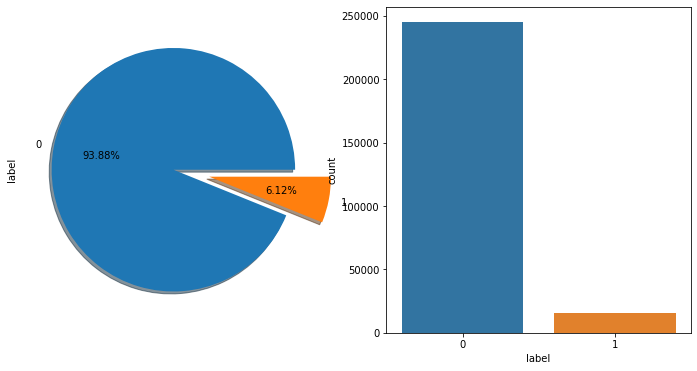

In [15]:
# 数据分布
label = train_data.groupby('label')['user_id'].count()
print('正负样本的数量：\n',label)
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
# autopct 保留几位小数 shadow 阴影 explode 偏移量
# value_counts()
train_data.label.value_counts().plot(kind='pie',autopct='%1.2f%%',shadow=True,explode=[0,0.3])

plt.subplot(1,2,2)
# countplot()
sns.countplot('label',data=train_data)

查看店铺数据对复购的影响

选取top5店铺
[4044, 3828, 4173, 1102, 4976]


C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


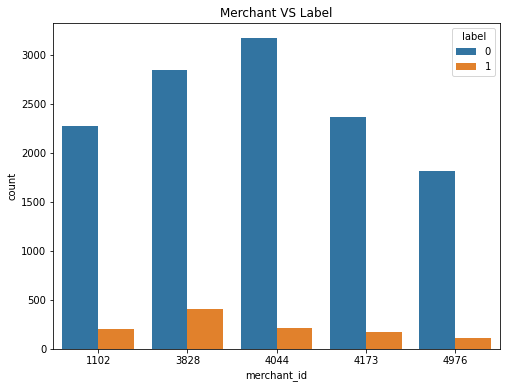

In [16]:
# 对店铺的分析 购买次数和是否购买图
print('选取top5店铺')
top_5_merchant = train_data.merchant_id.value_counts().head(5).index.tolist()
print(top_5_merchant)

train_data_merchant = train_data.copy()
train_data_merchant['Top'] = train_data_merchant['merchant_id'].apply(lambda x:1 if x in top_5_merchant else 0)
train_data_merchant = train_data_merchant[train_data_merchant['Top'] == 1]

plt.figure(figsize=(8,6))
plt.title('Merchant VS Label')
ax = sns.countplot('merchant_id',hue='label',data=train_data_merchant)

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


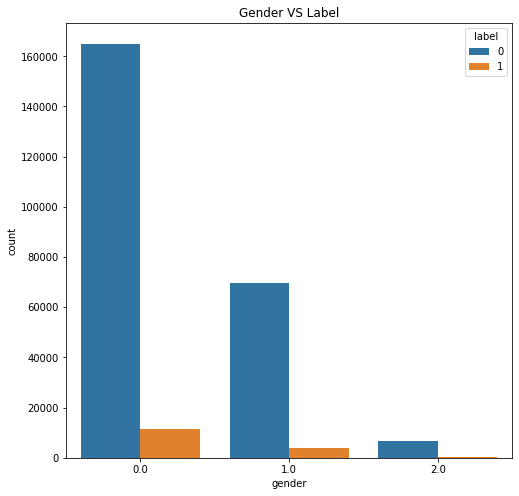

In [17]:
# 性别和复购的关系
train_data_user_info = train_data.merge(user_info,on=['user_id'],how='left')
plt.figure(figsize=(8,8))
plt.title('Gender VS Label')
ax = sns.countplot('gender',hue='label',data=train_data_user_info)

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


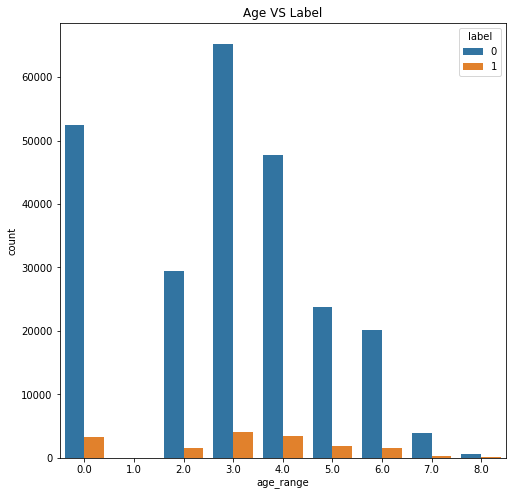

In [18]:
# 年龄和复购的关系 
plt.figure(figsize=(8,8))
plt.title('Age VS Label')
ax = sns.countplot('age_range',hue='label',data=train_data_user_info)

In [19]:
# 类别和复购的关系 
print('选取top5类别')
top_5_cat = train_data.cat_id.value_counts().head(5).index.tolist()
print(top_5_cat)


train_data_cat = train_data.copy()
train_data_cat['Top'] = train_data_cat['merchant_id'].apply(lambda x:1 if x in top_5_cat else 0)
train_data_cat = train_data_cat[train_data_cat['Top'] == 1]

plt.figure(figsize=(8,6))
plt.title('Category VS Label')
ax = sns.countplot('cat_id',hue='label',data=train_data_cat)

选取top5类别


AttributeError: 'DataFrame' object has no attribute 'cat_id'